# Creating a large database

In this section, we will take a look at techniques for creating a database for a large file or number of files.

In [1]:
import pandas as pd
from dfply import *

## Creating a large database with `pandas`

1. Read the first chunk and build cleaning functions.
2. Write the first section to a `db`
3. Use a for loop to <br>
    a. read a chuck<br>
    b. clean the chunk<br>
    c. append the chunk to the `db`<br>

## Example - Creating a Uber database with dateparts

Now we will use `pandas` to read, process and write the Uber data to a database.

## Step 1 - Inspect/clean the first chunk

It is important to automate the type specification and cleaning process. (based on previous work shown above)

#### Imports

In [2]:
from toolz import first
from calendar import day_name
import numpy as np
import pandas as pd
from dfply import *

#### default values

In [3]:
c_size = 10000
new_names = ['date', 'lat', 'lon', 'base']
date_cols = ['date']
weekday_categories = pd.CategoricalDtype(categories=list(day_name),
                                     ordered=True)

#### Create a data frame iterator and pull off the first chunk

In [4]:
c_size = 10000
file = "./data/uber-raw-data-apr14.csv"
df_iter = pd.read_csv(file, 
                      header=0, names=new_names,
                      parse_dates=date_cols,
                      sep=',',
                      engine='python',
                      chunksize=c_size)
first_chunk = next(df_iter)
first_chunk.head()

,date,lat,lon,base
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512


#### Expression for adding various date parts

In [5]:
from functoolz import pipeable
(first_chunk 
 >> mutate(weekday = X.date.dt.weekday_name,
           weekofyear = X.date.dt.weekofyear,
           dayofyear = X.date.dt.dayofyear,
           year = X.date.dt.year,
           month = X.date.dt.month_name(),
           day = X.date.dt.day,
           hour = X.date.dt.hour)
 >> head)

,date,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,Tuesday,14,91,2014,April,1,0
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,Tuesday,14,91,2014,April,1,0
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,Tuesday,14,91,2014,April,1,0
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,Tuesday,14,91,2014,April,1,0
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,Tuesday,14,91,2014,April,1,0


#### Create a functions for adding dateparts

In [6]:
from functoolz import pipeable
add_dateparts = pipeable(lambda df: (df >>
                                     mutate(weekday = X.date.dt.weekday_name,
                                            weekofyear = X.date.dt.weekofyear,
                                            dayofyear = X.date.dt.dayofyear,
                                            year = X.date.dt.year,
                                            month = X.date.dt.month_name(),
                                            day = X.date.dt.day,
                                            hour = X.date.dt.hour)
                                    >> drop(X.date)))
processed_first_chunk = first_chunk >> add_dateparts
processed_first_chunk.head(2)

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour
0,40.7690,-73.9549,B02512,Tuesday,14,91,2014,April,1,0
1,40.7267,-74.0345,B02512,Tuesday,14,91,2014,April,1,0


## Adding a primary key

* **Recall:** Primary keys need to be unique
* We will need to adjust the `id` column
* Make sure first `id` of next chunk is one more than the last

#### A function for adding an `id` column with a given starting value

In [7]:
add_primary_key = pipeable(lambda start, df: (df
                                              >> mutate(id = np.arange(start, start + len(df))
                                              )))

#### Playing around with different chunk indices

In [8]:
from dfply import head
i = 0
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) 
 >> head(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
0,40.769,-73.9549,B02512,Tuesday,14,91,2014,April,1,0,0


In [9]:
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> tail(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
9999,40.7656,-73.9697,B02512,Tuesday,15,98,2014,April,8,19,9999


In [10]:
i = 1
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> head(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
0,40.769,-73.9549,B02512,Tuesday,14,91,2014,April,1,0,10000


In [11]:
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> tail(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
9999,40.7656,-73.9697,B02512,Tuesday,15,98,2014,April,8,19,19999


In [12]:
i = 2
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> head(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
0,40.769,-73.9549,B02512,Tuesday,14,91,2014,April,1,0,20000


In [13]:
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) >> tail(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
9999,40.7656,-73.9697,B02512,Tuesday,15,98,2014,April,8,19,29999


#### Compose the helper functions

In [14]:
process_chunk = pipeable(lambda i, df, chunksize=c_size: df >> add_dateparts >> add_primary_key(i*c_size))
first_chunk >> process_chunk(0) >> tail(1)

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
9999,40.7656,-73.9697,B02512,Tuesday,15,98,2014,April,8,19,9999


#### Get the `sqlalchemy` types

In [15]:
from more_sqlalchemy import get_sql_types
i = 0
complete_first_chunk = first_chunk >> process_chunk(i)
sql_types = get_sql_types(complete_first_chunk)
sql_types

{'lat': sqlalchemy.sql.sqltypes.Float,
 'lon': sqlalchemy.sql.sqltypes.Float,
 'base': sqlalchemy.sql.sqltypes.String,
 'weekday': sqlalchemy.sql.sqltypes.String,
 'weekofyear': sqlalchemy.sql.sqltypes.Integer,
 'dayofyear': sqlalchemy.sql.sqltypes.Integer,
 'year': sqlalchemy.sql.sqltypes.Integer,
 'month': sqlalchemy.sql.sqltypes.String,
 'day': sqlalchemy.sql.sqltypes.Integer,
 'hour': sqlalchemy.sql.sqltypes.Integer,
 'id': sqlalchemy.sql.sqltypes.Integer}

## Step 2 - Read, process, and write the first chunk

Use `if_exists='replace'` on this first chuck.

#### Create a new database

In [16]:
!rm ./databases/uber.db

In [17]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///databases/uber.db', echo=False)

#### Get the sql schema and create the table

In [18]:
schema = pd.io.sql.get_schema(complete_first_chunk, # dataframe
                              'uber', # name in SQL db
                              keys='id', # primary key
                              con=engine, # connection
                              dtype=sql_types # SQL types
)
print(schema)
engine.execute(schema)


CREATE TABLE uber (
	lat FLOAT, 
	lon FLOAT, 
	base VARCHAR, 
	weekday VARCHAR, 
	weekofyear INTEGER, 
	dayofyear INTEGER, 
	year INTEGER, 
	month VARCHAR, 
	day INTEGER, 
	hour INTEGER, 
	id INTEGER NOT NULL, 
	CONSTRAINT uber_pk PRIMARY KEY (id)
)




## Step 3 - Getting the `df` iterator and read in each processed chunk


In [19]:
c_size = 10000
df_iter = enumerate(pd.read_csv("./data/uber-raw-data-apr14.csv", 
                                header=0, names=new_names, 
                                parse_dates=date_cols,
                                chunksize=c_size,
                                sep=',',
                                engine='python'))

In [20]:
for i, chunk in df_iter:
    processed_chunk = chunk >> process_chunk(i)
    print('writing chunk {0}'.format(i))
    processed_chunk.to_sql('uber', 
                           con=engine, 
                           dtype=sql_types, 
                           index=False,
                           if_exists='append')

writing chunk 0
writing chunk 1
writing chunk 2
writing chunk 3
writing chunk 4
writing chunk 5
writing chunk 6
writing chunk 7
writing chunk 8
writing chunk 9
writing chunk 10
writing chunk 11
writing chunk 12
writing chunk 13
writing chunk 14
writing chunk 15
writing chunk 16
writing chunk 17
writing chunk 18
writing chunk 19
writing chunk 20
writing chunk 21
writing chunk 22
writing chunk 23
writing chunk 24
writing chunk 25
writing chunk 26
writing chunk 27
writing chunk 28
writing chunk 29
writing chunk 30
writing chunk 31
writing chunk 32
writing chunk 33
writing chunk 34
writing chunk 35
writing chunk 36
writing chunk 37
writing chunk 38
writing chunk 39
writing chunk 40
writing chunk 41
writing chunk 42
writing chunk 43
writing chunk 44
writing chunk 45
writing chunk 46
writing chunk 47
writing chunk 48
writing chunk 49
writing chunk 50
writing chunk 51
writing chunk 52
writing chunk 53
writing chunk 54
writing chunk 55
writing chunk 56


## Step 4 - Query the database to test the results


In [21]:
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
engine2 = create_engine('sqlite:///databases/uber.db')
Base = automap_base()
Base.prepare(engine2, reflect=True)
Uber = Base.classes.uber

In [22]:
from sqlalchemy import select, func
stmt = (select([Uber.weekday, 
               func.count(Uber.weekday).label('cnt')])
        .group_by(Uber.weekday))
cnts = pd.read_sql_query(stmt, con=engine2)
cnts

,weekday,cnt
0,Friday,90303
1,Monday,60861
2,Saturday,77218
3,Sunday,51251
4,Thursday,85067
5,Tuesday,91185
6,Wednesday,108631


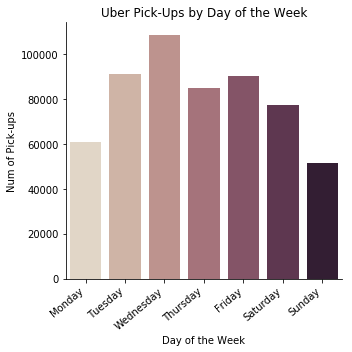

In [23]:
import seaborn as sns
%matplotlib inline
import matplotlib.pylab as plt
ax = (sns
      .catplot(x="weekday", 
               y = 'cnt',
               kind="bar", 
               order=day_name,
               palette="ch:.25", 
               data=cnts))

ax.set_xticklabels(ax.ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title='Uber Pick-Ups by Day of the Week',
       xlabel='Day of the Week', 
       ylabel='Num of Pick-ups')
plt.tight_layout()
plt.show()

## <font color="red"> Exercise 3 </font>

Add the data from the other 5 months to the database.  To do this

1. Use `glob` to get all the file names (filter out april).
2. Write a double `for` loop where
    a. The outer loop is over the file names
    b. The inner loop write each file, in chunks, to the database.
3. You will need keep track of the number of rows added using an accumulator.


Compute and visualize the hourly frequencies for Uber pick-ups for all 6 months, this time with `SQL` queries.

**Hint:** Recall that the primary key column, `id`, needs unique values.  You will need to adjust the `id` column in each chunk using `rows_so_far` (see below).

In [5]:
from glob import glob
files = glob('./data/uber/uber-trip-data/uber-raw-data-*.csv')
files = [f for f in files if 'apr' not in f]
files = [f for f in files if 'jan' not in f]
files

['./data/uber/uber-trip-data/uber-raw-data-aug14.csv',
 './data/uber/uber-trip-data/uber-raw-data-jul14.csv',
 './data/uber/uber-trip-data/uber-raw-data-jun14.csv',
 './data/uber/uber-trip-data/uber-raw-data-may14.csv',
 './data/uber/uber-trip-data/uber-raw-data-sep14.csv']

In [10]:
c_size = 10000
new_names = ['date', 'lat', 'lon', 'base']
date_cols = ['date']
weekday_categories = pd.CategoricalDtype(categories=list(day_name),
                                     ordered=True)

In [12]:
c_size = 10000
file = files[0]
df_iter = pd.read_csv(file, 
                      header=0, names=new_names,
                      parse_dates=date_cols,
                      sep=',',
                      engine='python',
                      chunksize=c_size)
first_chunk = next(df_iter)
first_chunk.head()

,date,lat,lon,base
0,2014-08-01 00:03:00,40.7366,-73.9906,B02512
1,2014-08-01 00:09:00,40.7260,-73.9918,B02512
2,2014-08-01 00:12:00,40.7209,-74.0507,B02512
3,2014-08-01 00:12:00,40.7387,-73.9856,B02512
4,2014-08-01 00:12:00,40.7323,-74.0077,B02512


In [13]:
from functoolz import pipeable
(first_chunk 
 >> mutate(weekday = X.date.dt.weekday_name,
           weekofyear = X.date.dt.weekofyear,
           dayofyear = X.date.dt.dayofyear,
           year = X.date.dt.year,
           month = X.date.dt.month_name(),
           day = X.date.dt.day,
           hour = X.date.dt.hour)
 >> head)

,date,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour
0,2014-08-01 00:03:00,40.7366,-73.9906,B02512,Friday,31,213,2014,August,1,0
1,2014-08-01 00:09:00,40.7260,-73.9918,B02512,Friday,31,213,2014,August,1,0
2,2014-08-01 00:12:00,40.7209,-74.0507,B02512,Friday,31,213,2014,August,1,0
3,2014-08-01 00:12:00,40.7387,-73.9856,B02512,Friday,31,213,2014,August,1,0
4,2014-08-01 00:12:00,40.7323,-74.0077,B02512,Friday,31,213,2014,August,1,0


In [14]:
from functoolz import pipeable
add_dateparts = pipeable(lambda df: (df >>
                                     mutate(weekday = X.date.dt.weekday_name,
                                            weekofyear = X.date.dt.weekofyear,
                                            dayofyear = X.date.dt.dayofyear,
                                            year = X.date.dt.year,
                                            month = X.date.dt.month_name(),
                                            day = X.date.dt.day,
                                            hour = X.date.dt.hour)
                                    >> drop(X.date)))
processed_first_chunk = first_chunk >> add_dateparts
processed_first_chunk.head(2)

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour
0,40.7366,-73.9906,B02512,Friday,31,213,2014,August,1,0
1,40.7260,-73.9918,B02512,Friday,31,213,2014,August,1,0


In [15]:
add_primary_key = pipeable(lambda start, df: (df
                                              >> mutate(id = np.arange(start, start + len(df))
                                              )))

In [16]:
from dfply import head
i = 0
(first_chunk >> add_dateparts 
 >> add_primary_key(i*c_size) 
 >> head(1))

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
0,40.7366,-73.9906,B02512,Friday,31,213,2014,August,1,0,0


In [17]:
process_chunk = pipeable(lambda i, df, chunksize=c_size: df >> add_dateparts >> add_primary_key(i*c_size))
first_chunk >> process_chunk(0) >> tail(1)

,lat,lon,base,weekday,weekofyear,dayofyear,year,month,day,hour,id
9999,40.7829,-73.9529,B02512,Saturday,32,221,2014,August,9,16,9999


In [18]:
from more_sqlalchemy import get_sql_types
i = 0
complete_first_chunk = first_chunk >> process_chunk(i)
sql_types = get_sql_types(complete_first_chunk)
sql_types

{'lat': sqlalchemy.sql.sqltypes.Float,
 'lon': sqlalchemy.sql.sqltypes.Float,
 'base': sqlalchemy.sql.sqltypes.String,
 'weekday': sqlalchemy.sql.sqltypes.String,
 'weekofyear': sqlalchemy.sql.sqltypes.Integer,
 'dayofyear': sqlalchemy.sql.sqltypes.Integer,
 'year': sqlalchemy.sql.sqltypes.Integer,
 'month': sqlalchemy.sql.sqltypes.String,
 'day': sqlalchemy.sql.sqltypes.Integer,
 'hour': sqlalchemy.sql.sqltypes.Integer,
 'id': sqlalchemy.sql.sqltypes.Integer}

In [28]:
!rm ./databases/uber.db

In [29]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///databases/uber.db', echo=False)

In [30]:
schema = pd.io.sql.get_schema(complete_first_chunk, # dataframe
                              'uber', # name in SQL db
                              keys='id', # primary key
                              con=engine, # connection
                              dtype=sql_types # SQL types
)
print(schema)
engine.execute(schema)


CREATE TABLE uber (
	lat FLOAT, 
	lon FLOAT, 
	base VARCHAR, 
	weekday VARCHAR, 
	weekofyear INTEGER, 
	dayofyear INTEGER, 
	year INTEGER, 
	month VARCHAR, 
	day INTEGER, 
	hour INTEGER, 
	id INTEGER NOT NULL, 
	CONSTRAINT uber_pk PRIMARY KEY (id)
)




In [31]:
c_size = 10000
df_iter = enumerate(pd.read_csv(files[0], 
                                header=0, names=new_names, 
                                parse_dates=date_cols,
                                chunksize=c_size,
                                sep=',',
                                engine='python'))

In [32]:
for i, chunk in df_iter:
    processed_chunk = chunk >> process_chunk(i)
    print('writing chunk {0}'.format(i))
    processed_chunk.to_sql('uber', 
                           con=engine, 
                           dtype=sql_types, 
                           index=False,
                           if_exists='append')

writing chunk 0
writing chunk 1
writing chunk 2
writing chunk 3
writing chunk 4
writing chunk 5
writing chunk 6
writing chunk 7
writing chunk 8
writing chunk 9
writing chunk 10
writing chunk 11
writing chunk 12
writing chunk 13
writing chunk 14
writing chunk 15
writing chunk 16
writing chunk 17
writing chunk 18
writing chunk 19
writing chunk 20
writing chunk 21
writing chunk 22
writing chunk 23
writing chunk 24
writing chunk 25
writing chunk 26
writing chunk 27
writing chunk 28
writing chunk 29
writing chunk 30
writing chunk 31
writing chunk 32
writing chunk 33
writing chunk 34
writing chunk 35
writing chunk 36
writing chunk 37
writing chunk 38
writing chunk 39
writing chunk 40
writing chunk 41
writing chunk 42
writing chunk 43
writing chunk 44
writing chunk 45
writing chunk 46
writing chunk 47
writing chunk 48
writing chunk 49
writing chunk 50
writing chunk 51
writing chunk 52
writing chunk 53
writing chunk 54
writing chunk 55
writing chunk 56
writing chunk 57
writing chunk 58
writing

In [34]:
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
engine2 = create_engine('sqlite:///databases/uber.db')
Base = automap_base()
Base.prepare(engine2, reflect=True)
Uber = Base.classes.uber

In [35]:
from sqlalchemy import select, func
stmt = (select([Uber.hour, 
               func.count(Uber.hour).label('cnt')])
        .group_by(Uber.hour))
cnts = pd.read_sql_query(stmt, con=engine2)
cnts

,hour,cnt
0,0,21451
1,1,14471
2,2,10105
3,3,10376
4,4,11774
5,5,16525
6,6,24907
7,7,34064
8,8,34566
9,9,30195


In [36]:
rows_so_far = cnts.cnt.sum()

In [37]:
!cp ./databases/uber.db ./databases/uber_months.db

In [38]:
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
eng_ex = create_engine('sqlite:///databases/uber_months.db')
Base = automap_base()
Base.prepare(eng_ex, reflect=True)
Uber = Base.classes.uber

In [39]:
c_size = 10000
df_iter = enumerate(pd.read_csv("./data/uber/uber-trip-data/uber-raw-data-may14.csv", 
                                header=0, names=new_names, 
                                parse_dates=date_cols,
                                chunksize=c_size,
                                sep=',',
                                engine='python'))

In [40]:
for i, chunk in df_iter:
    processed_chunk = chunk >> process_chunk(i) >> mutate(id = X.id + rows_so_far)
    print('writing chunk {0}'.format(i))
    processed_chunk.to_sql('uber', 
                           con=eng_ex, 
                           dtype=sql_types, 
                           index=False,
                           if_exists='append')

writing chunk 0
writing chunk 1
writing chunk 2
writing chunk 3
writing chunk 4
writing chunk 5
writing chunk 6
writing chunk 7
writing chunk 8
writing chunk 9
writing chunk 10
writing chunk 11
writing chunk 12
writing chunk 13
writing chunk 14
writing chunk 15
writing chunk 16
writing chunk 17
writing chunk 18
writing chunk 19
writing chunk 20
writing chunk 21
writing chunk 22
writing chunk 23
writing chunk 24
writing chunk 25
writing chunk 26
writing chunk 27
writing chunk 28
writing chunk 29
writing chunk 30
writing chunk 31
writing chunk 32
writing chunk 33
writing chunk 34
writing chunk 35
writing chunk 36
writing chunk 37
writing chunk 38
writing chunk 39
writing chunk 40
writing chunk 41
writing chunk 42
writing chunk 43
writing chunk 44
writing chunk 45
writing chunk 46
writing chunk 47
writing chunk 48
writing chunk 49
writing chunk 50
writing chunk 51
writing chunk 52
writing chunk 53
writing chunk 54
writing chunk 55
writing chunk 56
writing chunk 57
writing chunk 58
writing

In [42]:
from sqlalchemy import select, func
stmt = (select([Uber.hour, 
               func.count(Uber.hour).label('cnt')])
        .group_by(Uber.hour))
cnts_hour = pd.read_sql_query(stmt, con=eng_ex)
cnts_hour

,hour,cnt
0,0,35326
1,1,22657
2,2,15477
3,3,16322
4,4,18719
5,5,27314
6,6,45922
7,7,61477
8,8,60026
9,9,50702


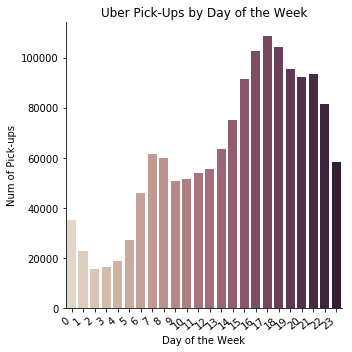

In [43]:
import seaborn as sns
%matplotlib inline
import matplotlib.pylab as plt
ax = (sns
      .catplot(x="hour", 
               y = 'cnt',
               kind="bar", 
               palette="ch:.25", 
               data=cnts_hour))

ax.set_xticklabels(ax.ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title='Uber Pick-Ups by Day of the Week',
       xlabel='Day of the Week', 
       ylabel='Num of Pick-ups')
plt.tight_layout()
plt.show()

## Up Next

Stuff